In [8]:
import pandas as pd

In [9]:
def wrangle(filepath):
    #reading the file into a dataframe
    df = pd.read_csv(filepath)
    
    #dropping columns having mostly null values
    df.drop(columns = ["Unnamed: 26", "Unnamed: 27", 
                       "Unnamed: 28", "Unnamed: 29", "Unnamed: 30"], inplace = True, axis = 1)
    
    #dropping columns having high cardinality(too many distinct values)
    df.drop(columns = ["sourceURLs", "imageURLs", 
                       "prices.sourceURLs", "asins", "manufacturerNumber", "keys"], inplace = True)
    
    #changing column names
    df.columns = df.columns.str.replace("prices.", "")
    
    #Replacing values in columns with appropriate values
    df["availability"].replace({"yes" : "In Stock", 
                                "Yes" : "In Stock", 
                                "TRUE" : "In Stock", 
                                "sold" : "Out Of Stock",
                                "No" : "Out Of Stock",
                                "FALSE" : "Out Of Stock",
                                }, inplace = True)
    
    df["condition"].replace({"new": "New", "New other (see details)" : "New", "pre-owned" : "Used", 
                             "refurbished" : "Refurbished", "Seller refurbished" : "Refurbished",
                            "Manufacturer refurbished" : "Refurbished"}, inplace = True)
    
    #dropping rowns having lengthy "condition" values
    for i in range(0, df.shape[0]):
        if len(df["condition"][i]) > 15:
            df.drop([i], inplace = True)
        else:
            pass
    
    #reformatting date columns
    date_cols = ["dateAdded", "dateUpdated", "dateSeen"]
    for col in date_cols:
        df[col] = df[col].str[0:10].apply(pd.to_datetime)
        
    #reformatting weight column (this column had many irregularities)
    df.weight = df.weight.str[:4]
    df.weight = df.weight.str.replace("[A-Za-z]" , "" ).replace(" ", "")
    df.drop(df.loc[df.weight == ""].index, inplace = True)
    df.weight = df.weight.astype(float)
    
    #converting CAD to USD
    CAD_index = df.loc[df.currency == "CAD"].index
    for i in CAD_index:
        df.amountMin = df.amountMin * 0.77
        df.amountMax = df.amountMax * 0.77
        
    #dropping currency columns as it has only one entry
    df.drop(["currency"], axis = 1, inplace = True)
    
    
    return df 

In [10]:
df = wrangle("../sample.csv")

/tmp/ipykernel_29454/1073907403.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("prices.", "")
/tmp/ipykernel_29454/1073907403.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  df.weight = df.weight.str.replace("[A-Za-z]" , "" ).replace(" ", "")


In [11]:
df.columns

Index(['id', 'amountMax', 'amountMin', 'availability', 'condition', 'dateSeen',
       'isSale', 'merchant', 'shipping', 'brand', 'categories', 'dateAdded',
       'dateUpdated', 'ean', 'manufacturer', 'name', 'primaryCategories',
       'upc', 'weight'],
      dtype='object')

In [12]:
df.weight.describe()

count    7213.00000
mean       15.35377
std        46.01716
min         0.00000
25%         2.00000
50%         5.78000
75%        15.20000
max       885.00000
Name: weight, dtype: float64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7213 entries, 0 to 7248
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 7213 non-null   object        
 1   amountMax          7213 non-null   float64       
 2   amountMin          7213 non-null   float64       
 3   availability       7213 non-null   object        
 4   condition          7213 non-null   object        
 5   dateSeen           7213 non-null   datetime64[ns]
 6   isSale             7213 non-null   bool          
 7   merchant           7213 non-null   object        
 8   shipping           4253 non-null   object        
 9   brand              7213 non-null   object        
 10  categories         7213 non-null   object        
 11  dateAdded          7213 non-null   datetime64[ns]
 12  dateUpdated        7213 non-null   datetime64[ns]
 13  ean                1543 non-null   object        
 14  manufact

In [14]:
df.primaryCategories.value_counts().sort_values()

Electronics,Furniture       8
 Intel Celeron             12
Electronics              7193
Name: primaryCategories, dtype: int64

In [15]:
df.isSale.value_counts()

False    5479
True     1734
Name: isSale, dtype: int64

<AxesSubplot:>

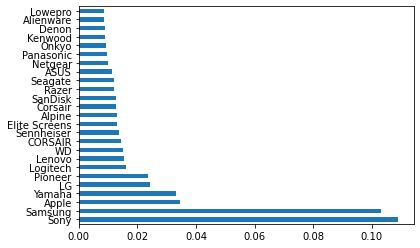

In [16]:
df.brand.value_counts(normalize = True).head(25).plot(kind = "barh")

In [17]:
df.shipping.value_counts().head()

Free Expedited Shipping for most orders over $49    1449
FREE                                                 727
Value                                                687
Standard                                             651
Expedited                                            410
Name: shipping, dtype: int64

In [18]:
df.merchant.value_counts()

Bestbuy.com          2794
bhphotovideo.com     1509
Walmart.com           664
Beach Camera          201
AMI Ventures Inc       62
                     ... 
ryajoh7                 1
shopdivvy               1
happychicken-com        1
sunshineworld8689       1
apc_sales               1
Name: merchant, Length: 689, dtype: int64

In [19]:
df.isSale.value_counts()

False    5479
True     1734
Name: isSale, dtype: int64

In [20]:
df.condition.value_counts()

New            6985
Used            145
Refurbished      83
Name: condition, dtype: int64

In [21]:
df.availability.value_counts()

In Stock           6828
Out Of Stock        142
Special Order       109
More on the Way      91
undefined            40
Retired               1
32 available          1
7 available           1
Name: availability, dtype: int64

In [22]:
df_top_merchants = (
    df["merchant"]
    .value_counts(normalize = True)
    .sort_values(ascending = False)
    .head(20)
)
df_top_merchants["others"] = 1 - df_top_merchants.sum()
df_top_merchants = df_top_merchants.to_frame()

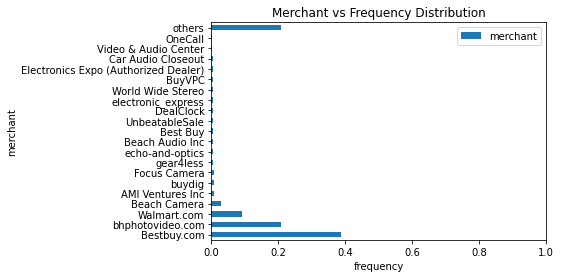

In [23]:
df_top_merchants.plot.barh(xlim = (0,1))
import matplotlib.pyplot as plt
plt.xlabel("frequency")
plt.ylabel("merchant")
plt.title("Merchant vs Frequency Distribution");

In [24]:
df.head()

,id,amountMax,amountMin,availability,condition,dateSeen,isSale,merchant,shipping,brand,categories,dateAdded,dateUpdated,ean,manufacturer,name,primaryCategories,upc,weight
0,AVphzgbJLJeJML43fA0o,80.8423,80.8423,In Stock,New,2017-03-30,False,Bestbuy.com,NaN,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",2015-04-13,2018-05-12,NaN,NaN,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,7.94E+11,32.8
1,AVpgMuGwLJeJML43KY_c,53.1300,50.0423,In Stock,New,2017-12-14,True,Walmart.com,Expedited,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
2,AVpgMuGwLJeJML43KY_c,53.1300,53.1300,In Stock,New,2017-09-08,False,Walmart.com,Expedited,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
3,AVpgMuGwLJeJML43KY_c,53.8923,53.8923,In Stock,New,2017-10-10,False,Bestbuy.com,NaN,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
4,AVpgMuGwLJeJML43KY_c,51.5823,51.5823,In Stock,New,2017-08-28,False,Bestbuy.com,NaN,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0


In [25]:
df.describe()

,amountMax,amountMin,weight
count,7213.00000,7213.000000,7213.00000
mean,381.73947,357.316435,15.35377
std,589.38617,525.241112,46.01716
min,0.77000,0.770000,0.00000
25%,61.59230,61.276600,2.00000
50%,152.46000,145.530000,5.78000
75%,380.38000,368.830000,15.20000
max,5389.99230,4619.992300,885.00000


In [26]:
df.amountMin.corr(df.amountMax)

0.9704327465548521

In [27]:
df.isnull().sum()*100/(df.shape[0])

id                    0.000000
amountMax             0.000000
amountMin             0.000000
availability          0.000000
condition             0.000000
dateSeen              0.000000
isSale                0.000000
merchant              0.000000
shipping             41.037016
brand                 0.000000
categories            0.000000
dateAdded             0.000000
dateUpdated           0.000000
ean                  78.608069
manufacturer         55.538611
name                  0.000000
primaryCategories     0.000000
upc                   0.000000
weight                0.000000
dtype: float64

In [32]:
df["id"].value_counts().head(20)

AV1YFZVDvKc47QAVgp7V    59
AVs4jJ0Vnnc1JgDc4w40    53
AVrI3KE1U2_QcyX9O9Iw    52
AVzxqGmivKc47QAVfTIA    45
AVqkH8TtU2_QcyX9O0rJ    45
AVwjdOdov8e3D1O-nnK9    44
AVzSv0q-vKc47QAVd60B    42
AVqkEzW9U2_QcyX9O0Gr    42
AVqVGUFCv8e3D1O-ldFF    39
AV1YDsmoGV-KLJ3adcbe    39
AV1YHofqglJLPUi8IGyn    39
AVpf4W5_ilAPnD_xj6lg    36
AVpe6fQ1ilAPnD_xQvv9    35
AVwjc_-jv8e3D1O-nnKy    35
AVpfWGrYLJeJML437hk2    34
AVpfHjh7LJeJML432w1s    33
AVqkH8PGU2_QcyX9O0rI    32
AV1YDIi6vKc47QAVgpcL    30
AV1cIKWjglJLPUi8IVZ6    30
AVpflg8PilAPnD_xefyM    29
Name: id, dtype: int64

In [37]:
df[["id", "name"]].groupby(["id", "name"])

In [38]:
df.categories.nunique()

801

In [42]:
df.groupby("dateSeen").count()

,id,amountMax,amountMin,availability,condition,isSale,merchant,shipping,brand,categories,dateAdded,dateUpdated,ean,manufacturer,name,primaryCategories,upc,weight
dateSeen,,,,,,,,,,,,,,,,,,
2014-08-30,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
2014-08-31,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
2014-09-04,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2014-09-06,3,3,3,3,3,3,3,3,3,3,3,3,1,1,3,3,3,3
2014-09-28,3,3,3,3,3,3,3,3,3,3,3,3,0,2,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-18,18,18,18,18,18,18,18,0,18,18,18,18,0,7,18,18,18,18
2018-06-19,46,46,46,46,46,46,46,38,46,46,46,46,5,11,46,46,46,46
2018-06-20,49,49,49,49,49,49,49,29,49,49,49,49,9,23,49,49,49,49


In [41]:
df.

,id,amountMax,amountMin,availability,condition,dateSeen,isSale,merchant,shipping,brand,categories,dateAdded,dateUpdated,ean,manufacturer,name,primaryCategories,upc,weight
0,AVphzgbJLJeJML43fA0o,80.8423,80.8423,In Stock,New,2017-03-30,False,Bestbuy.com,NaN,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",2015-04-13,2018-05-12,NaN,NaN,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,7.94E+11,32.8
1,AVpgMuGwLJeJML43KY_c,53.1300,50.0423,In Stock,New,2017-12-14,True,Walmart.com,Expedited,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
2,AVpgMuGwLJeJML43KY_c,53.1300,53.1300,In Stock,New,2017-09-08,False,Walmart.com,Expedited,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
3,AVpgMuGwLJeJML43KY_c,53.8923,53.8923,In Stock,New,2017-10-10,False,Bestbuy.com,NaN,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
4,AVpgMuGwLJeJML43KY_c,51.5823,51.5823,In Stock,New,2017-08-28,False,Bestbuy.com,NaN,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18,2018-06-13,NaN,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,6.42E+11,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7244,AVpfUsrxLJeJML437Ezd,61.5923,61.5923,In Stock,New,2017-10-10,False,Bestbuy.com,NaN,Lowepro,"Camera & Photo Accessories,Cameras, Camcorders...",2016-06-10,2018-06-13,NaN,Lowepro,Lowepro - Slingshot Edge 250 AW Camera Backpac...,Electronics,56035368998,1.8
7245,AVpfUsrxLJeJML437Ezd,52.9375,52.9375,In Stock,New,2018-06-01,False,bhphotovideo.com,Free Expedited Shipping for most orders over $49,Lowepro,"Camera & Photo Accessories,Cameras, Camcorders...",2016-06-10,2018-06-13,NaN,Lowepro,Lowepro - Slingshot Edge 250 AW Camera Backpac...,Electronics,56035368998,1.8
7246,AVpfUsrxLJeJML437Ezd,54.6623,54.6623,In Stock,New,2017-05-18,False,Bestbuy.com,NaN,Lowepro,"Camera & Photo Accessories,Cameras, Camcorders...",2016-06-10,2018-06-13,NaN,Lowepro,Lowepro - Slingshot Edge 250 AW Camera Backpac...,Electronics,56035368998,1.8
7247,AVpfUsrxLJeJML437Ezd,55.4323,55.4323,In Stock,New,2017-08-28,False,Bestbuy.com,NaN,Lowepro,"Camera & Photo Accessories,Cameras, Camcorders...",2016-06-10,2018-06-13,NaN,Lowepro,Lowepro - Slingshot Edge 250 AW Camera Backpac...,Electronics,56035368998,1.8


In [44]:
df.availability.value_counts()

In Stock           6828
Out Of Stock        142
Special Order       109
More on the Way      91
undefined            40
Retired               1
32 available          1
7 available           1
Name: availability, dtype: int64

In [92]:
Out_of_Stock = (df[df["availability"] == "Out Of Stock"][["id", "name", "upc", "manufacturer" ]]
                .reset_index()
                .drop("index", axis = 1)
                .drop_duplicates(subset = ["id"]))
Out_of_Stock

,id,name,upc,manufacturer
0,AVpfLsb-ilAPnD_xWtDE,Kenwood KFC-1653MRW 6.5 2-way Marine Speakers ...,19048210340,Kenwood
1,AVpgF1BOilAPnD_xnTsK,iHome Rechargeable Splash Proof Stereo Bluetoo...,47532907711,iHome
2,AV1YFmcQglJLPUi8IGd1,Corsair CMSA8GX3M2A1066C7 Apple 8 GB Dual Chan...,8.44E+11,NaN
3,AVpiLlubilAPnD_xBoTa,House of Marley Smile Jamaica In-Ear Earbuds,8.47E+11,House Of Marley
4,AVpfC6mu1cnluZ0-cszY,Russound - Acclaim 5 Series 5-1/4 2-Way Indoor...,6.13E+11,Russound
...,...,...,...,...
136,AVqVGVn7nnc1JgDc3jFw,"Insignia - Fixed TV Wall Mount For Most 40-70""...",6.01E+11,NaN
137,AVpidQq2ilAPnD_xEWbV,CORSAIR - VENGEANCE LPX Series 32GB (2PK 16GB)...,8.44E+11,NaN
138,AVqVGH9Ynnc1JgDc3jDV,Details About Kenwood Ddx375bt Car Double Din ...,19048216588,KENWOOD
140,AV1YDKV-glJLPUi8IF6T,VS278Q-P 27 16:9 LCD Monitor,8.86E+11,NaN


In [83]:
product_manufacturer = df[["id", "manufacturer"]].drop_duplicates(subset = ['id'])

In [84]:
product_manufacturer

,id,manufacturer
0,AVphzgbJLJeJML43fA0o,NaN
1,AVpgMuGwLJeJML43KY_c,Boytone
13,AVpe9FXeLJeJML43zHrq,Dantona
18,AVpfVJXu1cnluZ0-iwTT,NaN
23,AVphUeKeilAPnD_x3-Be,YAMAHA
...,...,...
7213,AVpirqtQilAPnD_xGjJb,NaN
7221,AVpfSIe2ilAPnD_xYy87,Audioquest
7223,AVpggdNaLJeJML43O2qK,NaN
7231,AWFFBU8JIwln0LfXiLtO,NaN


In [71]:
product_manufacturer.groupby("manufacturer")["id"].count().tail(20)

manufacturer
Tiffen                         9
Urban Armor Gear               7
V-Moda                        35
Viper by GLD Products          9
Visiontek                      8
Vizio                         17
Western Digital               37
Westone Laboratories, Inc.    14
YAMAHA                        31
Yamaha                        69
Yamaha Electronics            19
ZTE                            5
Zagg                           9
Zmodo                          6
Zoom                          27
eTape16                        6
iHome                         17
iSimple                       19
niles                          5
x6d inc                        3
Name: id, dtype: int64

In [75]:
product_manufacturer = df[["id", "manufacturer"]]

In [76]:
product_manufacturer

,id,manufacturer
0,AVphzgbJLJeJML43fA0o,NaN
1,AVpgMuGwLJeJML43KY_c,Boytone
2,AVpgMuGwLJeJML43KY_c,Boytone
3,AVpgMuGwLJeJML43KY_c,Boytone
4,AVpgMuGwLJeJML43KY_c,Boytone
...,...,...
7244,AVpfUsrxLJeJML437Ezd,Lowepro
7245,AVpfUsrxLJeJML437Ezd,Lowepro
7246,AVpfUsrxLJeJML437Ezd,Lowepro
7247,AVpfUsrxLJeJML437Ezd,Lowepro


In [77]:
df.manufacturer.nunique()

198

In [86]:
product_manufacturer = df[["id", "manufacturer"]].dropna().drop_duplicates()
product_manufacturer

,id,manufacturer
1,AVpgMuGwLJeJML43KY_c,Boytone
13,AVpe9FXeLJeJML43zHrq,Dantona
23,AVphUeKeilAPnD_x3-Be,YAMAHA
33,AVpf0Nyo1cnluZ0-rzhu,Bose
58,AVpgGPyq1cnluZ0-wbTJ,Motorola
...,...,...
7156,AVqVGH9Ynnc1JgDc3jDV,KENWOOD
7167,AVpfMVD-ilAPnD_xW6bu,Sony
7179,AVpe-TEYilAPnD_xSIIL,Manufacturers Limited Warranty:3 Year
7221,AVpfSIe2ilAPnD_xYy87,Audioquest


In [89]:
unreal_manufacturers = product_manufacturer.loc[product_manufacturer["manufacturer"].str.contains("arranty")].index

In [91]:
product_manufacturer.drop(unreal_manufacturers, axis = 0, inplace = True)
product_manufacturer

,id,manufacturer
1,AVpgMuGwLJeJML43KY_c,Boytone
13,AVpe9FXeLJeJML43zHrq,Dantona
23,AVphUeKeilAPnD_x3-Be,YAMAHA
33,AVpf0Nyo1cnluZ0-rzhu,Bose
58,AVpgGPyq1cnluZ0-wbTJ,Motorola
...,...,...
7121,AVqVHCeSv8e3D1O-ldKD,Panasonic
7156,AVqVGH9Ynnc1JgDc3jDV,KENWOOD
7167,AVpfMVD-ilAPnD_xW6bu,Sony
7221,AVpfSIe2ilAPnD_xYy87,Audioquest
